## Set up workspace

In [18]:
# Standard library imports
import glob
import math
import os
import time

# Third-party library imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Function, Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import models

## Set up dataset

In [19]:
#Helper functions for pose preprocessing 
def isRotationMatrix(R):
    """ Checks if a matrix is a valid rotation matrix
        referred from https://www.learnopencv.com/rotation-matrix-to-euler-angles/
    """
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-6

def rotationMatrixToEulerAngles(R):
    """ calculates rotation matrix to euler angles
        referred from https://www.learnopencv.com/rotation-matrix-to-euler-angles
    """
    assert(isRotationMatrix(R))
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
    singular = sy < 1e-6

    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0

    return np.array([x, y, z])

def getMatrix(line):
    p = np.array([line[3], line[7], line[11]])
    R = np.array([[line[0],line[1],line[2]],
                [line[4],line[5],line[6]],
                [line[8],line[9],line[10]]])
    angles = rotationMatrixToEulerAngles(R)
    matrix = np.concatenate((p,angles))
    return matrix

In [20]:
# Define dataset class
class KITTI_Dataset(Dataset):
    def __init__(self, images_path, poses_path, sequences=['00']):
        self.images_path = images_path
        self.poses_path = poses_path
        self.sequences = sequences # list of sequences to be considered
        self.endings = {} # for each sequence, save global idx at which seq ends
        self.image_files = self.load_image_files()
        self.pose_files = self.load_pose_files()

    # Returns list of image paths where images can be retrieved.
    def load_image_files(self):
        image_files = []
        count = 0
        for seq in self.sequences:
            for root, _, files in os.walk(os.path.join(self.images_path, seq, 'image_0')):
                for file in sorted(files):
                    if file.endswith('.png'):
                        image_files.append(os.path.join(root, file))
                        count += 1
            self.endings[seq] = count
        return image_files

    # Returns dictionary of pose paths where poses can be retrieved
    # Entries are of the form '03': 'this/is/a/path'
    def load_pose_files(self):
        pose_files = {}
        for seq in self.sequences:
            pose_file = os.path.join(self.poses_path, seq+'.txt')
            if os.path.exists(pose_file):
                if os.path.exists(pose_file):
                    try:
                        np.loadtxt(pose_file, dtype=np.float32)
                        pose_files[seq] = pose_file
                    except Exception as e:
                        print(f"Error loading pose file {pose_file}: {e}")
                else:
                    print(f"Pose file missing: {pose_file}")
        return pose_files

    # Opens an image at the given path in grayscale, normalizes it, and resizes it
    def open_image(self, img_path):
        img = Image.open(img_path).convert('L')  # Load as grayscale
        img = np.array(img, dtype=np.float32) / 255.0
        img = (img - 0.5) / 0.5
        img = cv2.resize(img, (1280,384), cv2.INTER_LINEAR)
        return img

    def __len__(self):
        return len(self.image_files)

    # Retrieves the item at idx, which is composed of 
    # 1. An image in a sequence concatenated with its successor (if it doesn't exist, with itself)
    # 2. The difference in poses between the image and its successor in 6DOF matrix form
    def __getitem__(self, idx):
        #print(f"Fetching index {idx}/{len(self.image_files)}")

        # 1. Load the image
        img_path_1 = self.image_files[idx]
        seq = os.path.basename(os.path.dirname(os.path.dirname(img_path_1)))
        img_path_2 = img_path_1 if idx == self.endings[seq] - 1 else self.image_files[idx + 1]

        img_1 = self.open_image(img_path_1)
        img_2 = self.open_image(img_path_2)
        img = np.concatenate([img_1, img_2], axis = -1)
        img = np.reshape(img, (2, 384, 1280))
       
        # 2. Load corresponding pose if available
        pose = None
        if seq in self.pose_files:
            img_idx = int(os.path.basename(img_path_1).split('.')[0])
            pose_file = self.pose_files[seq]
            
            with open(pose_file, 'r') as f:
                lines = f.readlines()     
                line_1 = np.fromstring(lines[img_idx], dtype=float, sep=' ')
                line_2 = line_1 if idx == self.endings[seq] - 1 else np.fromstring(lines[img_idx + 1], dtype=float, sep=' ')
                
            pose_1 = getMatrix(line_1)
            pose_2 = getMatrix(line_2)
            pose = pose_2 - pose_1

        # Return pair (image, pose)
        return torch.FloatTensor(img), torch.FloatTensor(pose)

## Network architecture

In [21]:
#Defining neural network as per RP by Sen Wang
class DeepVONet(nn.Module):
    def __init__(self):
        super(DeepVONet, self).__init__()

        self.conv1 = nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)) #6 64
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d (64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d (128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu3 = nn.ReLU(inplace=True)
        self.conv3_1 = nn.Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv4 = nn.Conv2d (256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU(inplace=True)
        self.conv4_1 = nn.Conv2d (512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv5 = nn.Conv2d (512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu5 = nn.ReLU(inplace=True)
        self.conv5_1 = nn.Conv2d (512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv6 = nn.Conv2d (512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.lstm1 = nn.LSTMCell(20*6*1024, 100)
        self.lstm2 = nn.LSTMCell(100, 100)
        self.fc = nn.Linear(in_features=100, out_features=6)

        self.reset_hidden_states()

    def reset_hidden_states(self, size=10, zero=True):
        if zero == True:
            self.hx1 = Variable(torch.zeros(size, 100))
            self.cx1 = Variable(torch.zeros(size, 100))
            self.hx2 = Variable(torch.zeros(size, 100))
            self.cx2 = Variable(torch.zeros(size, 100))
        else:
            self.hx1 = Variable(self.hx1.data)
            self.cx1 = Variable(self.cx1.data)
            self.hx2 = Variable(self.hx2.data)
            self.cx2 = Variable(self.cx2.data)

        if next(self.parameters()).is_cuda == True:
            self.hx1 = self.hx1.cuda()
            self.cx1 = self.cx1.cuda()
            self.hx2 = self.hx2.cuda()
            self.cx2 = self.cx2.cuda()

    def forward(self, x):
        #self.reset_hidden_states()
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv3_1(x)
        x = self.relu3_1(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.conv4_1(x)
        x = self.relu4_1(x)
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.conv5_1(x)
        x = self.relu5_1(x)
        x = self.conv6(x)
        #print(x.size())
        x = x.view(x.size(0), 20 * 6 * 1024)
        #print(x.size())
        self.hx1, self.cx1 = self.lstm1(x, (self.hx1, self.cx1))
        x = self.hx1
        self.hx2, self.cx2 = self.lstm2(x, (self.hx2, self.cx2))
        x = self.hx2
        #print(x.size())
        x = self.fc(x)
        return x

## Set up training

In [22]:
# Training Function
def training_model(model, data_loader, device, epochs):

    train_losses = []
    start_time = time.time()
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        
        print("Epoch : ", epoch+1)
        running_loss = 0.0
        model.train()
        
        for batch_idx, (images, poses) in enumerate(data_loader):
            # Discard last batch to avoid conflict with RNN
            if batch_idx == len(data_loader)-1:
                break
            #print("Batch number:", batch_idx+1)
            
            inputs = images.to(device)
            labels = poses.to(device)
            optimizer.zero_grad()
            model.reset_hidden_states()
            outputs = model(inputs)
            #print(inputs)
            #print(labels)
            #print(outputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        train_losses.append(running_loss)
        print('Epoch : %d Loss: %.3f' %(epoch+1, running_loss))

    print('Train losses:')
    print(train_losses)

    print('Finished Training')
    print ("Time taken in Training {0}".format((time.time() - start_time)))

    return train_losses 

## Training

In [23]:
print(torch.cuda.is_available())  # Should print True
print(torch.cuda.get_device_name(0))  # Should display your GPU name
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

True
NVIDIA GeForce RTX 3060 Laptop GPU


In [24]:
"""
import torch.nn.init as init
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            # Xavier (Glorot) initialization for Conv2d layers
            init.xavier_uniform_(m.weight)
            if m.bias is not None:
                init.zeros_(m.bias)
        elif isinstance(m, nn.Linear):
            # Kaiming He initialization for Linear layers
            init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                init.zeros_(m.bias)
"""

"\nimport torch.nn.init as init\ndef initialize_weights(model):\n    for m in model.modules():\n        if isinstance(m, nn.Conv2d):\n            # Xavier (Glorot) initialization for Conv2d layers\n            init.xavier_uniform_(m.weight)\n            if m.bias is not None:\n                init.zeros_(m.bias)\n        elif isinstance(m, nn.Linear):\n            # Kaiming He initialization for Linear layers\n            init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')\n            if m.bias is not None:\n                init.zeros_(m.bias)\n"

In [25]:
#Creating model and defining loss and optimizer to be used 
model = DeepVONet().to(device)
#initialize_weights(model)
criterion = torch.nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5, weight_decay=0.5)

In [26]:
data_path = 'C:\\Users\\benja\\Desktop\\visual-odometry'
images_path = os.path.join(data_path,'data_odometry_gray\\dataset\\sequences')
poses_path = os.path.join(data_path,'data_odometry_poses\\dataset\\poses')
sequences = ['03']
#sequences = ['01','03','06']

dataset = KITTI_Dataset(images_path, poses_path, sequences)
data_loader = DataLoader(dataset, batch_size=10, shuffle=False, num_workers=0, pin_memory=True)

In [27]:
train_losses = training_model(model=model, data_loader=data_loader, device=device, epochs=10)

Epoch :  1
Epoch : 1 Loss: 5.871
Epoch :  2
Epoch : 2 Loss: 5.500
Epoch :  3
Epoch : 3 Loss: 5.223
Epoch :  4
Epoch : 4 Loss: 5.008
Epoch :  5
Epoch : 5 Loss: 4.836
Epoch :  6
Epoch : 6 Loss: 4.694
Epoch :  7
Epoch : 7 Loss: 4.576
Epoch :  8
Epoch : 8 Loss: 4.477
Epoch :  9
Epoch : 9 Loss: 4.393
Epoch :  10
Epoch : 10 Loss: 4.322
Train losses:
[5.871137979673222, 5.499633772997186, 5.223365303478204, 5.008410539245233, 4.835801809269469, 4.694186093984172, 4.576277198619209, 4.477119967341423, 4.393151018361095, 4.321689463336952]
Finished Training
Time taken in Training 273.98031544685364


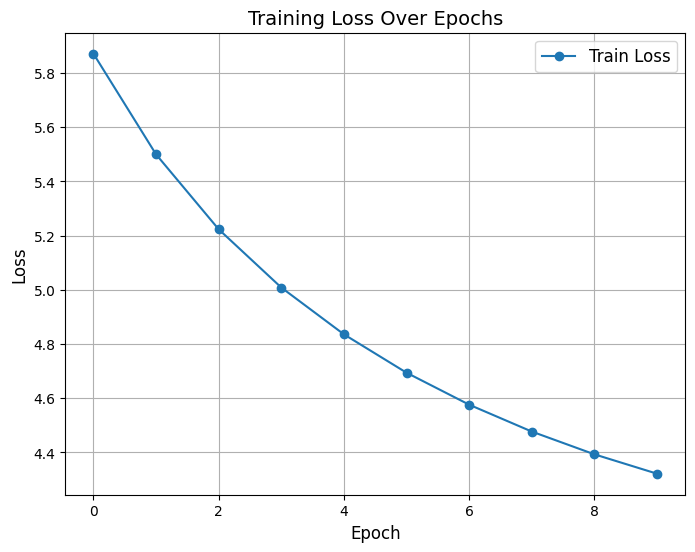

In [28]:
# Create a plot
plt.figure(figsize=(8, 6))
plt.plot(train_losses, marker='o', label='Train Loss')

# Add labels and title
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Over Epochs', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)

# Show the plot
plt.show()

In [29]:
#Save the model
torch.save(model.state_dict(), 'DeepVO.pt')

## Inference

In [30]:
print(torch.cuda.is_available())  # Should print True
print(torch.cuda.get_device_name(0))  # Should display your GPU name
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

True
NVIDIA GeForce RTX 3060 Laptop GPU


In [39]:
data_path = 'C:\\Users\\benja\\Desktop\\visual-odometry'
images_path = os.path.join(data_path,'data_odometry_gray\\dataset\\sequences')
poses_path = os.path.join(data_path,'data_odometry_poses\\dataset\\poses')
sequences = ['03']

dataset_test = KITTI_Dataset(images_path, poses_path, sequences)
data_loader_test = DataLoader(dataset_test, batch_size=10, shuffle=False, num_workers=0, pin_memory=True)

In [40]:
#Load model
model = DeepVONet().to(device)
model.load_state_dict(torch.load("DeepVO.pt", map_location=device))
model.eval()

C:\Users\benja\AppData\Local\Temp\ipykernel_22112\878473083.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("DeepVO.pt", map_location=de

DeepVONet(
  (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (relu3): ReLU(inplace=True)
  (conv3_1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU(inplace=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu4): ReLU(inplace=True)
  (conv4_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4_1): ReLU(inplace=True)
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu5): ReLU(inplace=True)
  (conv5_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5_1): ReLU(inplace=True)
  (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (lstm1): LSTMCell(122880, 1

In [ ]:
outputs = []
with torch.no_grad():
    for batch_idx, (images, poses) in enumerate(data_loader):
        #print(batch_idx)
        if batch_idx == len(data_loader)-1:
            break
        inputs = images.to(device)
        model.reset_hidden_states()
        output = model(inputs).detach().cpu()
        #if batch_idx in [0,1,2,3,4]:
            #print(images[0][0])
            #print(inputs[0][0])
            #print(output)
            #print(poses)
        print(output)
        outputs.append(output)

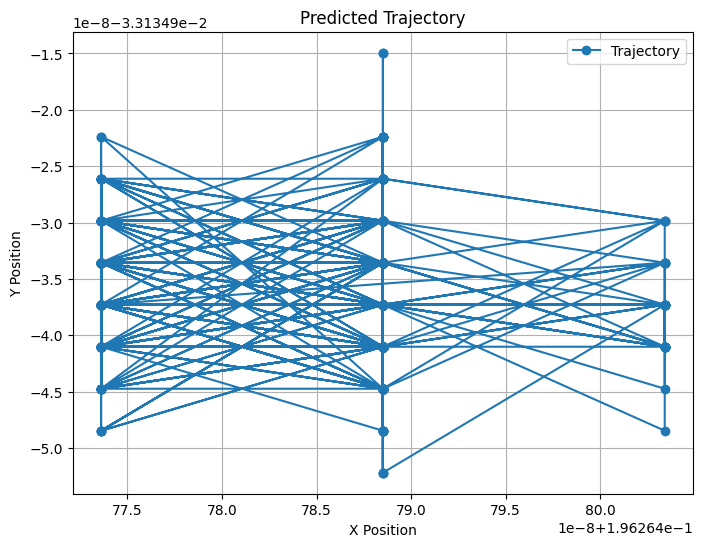

In [42]:
import matplotlib.pyplot as plt
import torch

all_outputs = torch.cat(outputs, dim=0)  # Concatenate along batch dimension

x_positions = all_outputs[:, 0].cpu().numpy()
y_positions = all_outputs[:, 1].cpu().numpy()

# Plot the x, y positions
plt.figure(figsize=(8, 6))
plt.plot(x_positions, y_positions, marker='o', linestyle='-', label="Trajectory")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Predicted Trajectory")
plt.legend()
plt.grid(True)
plt.show()

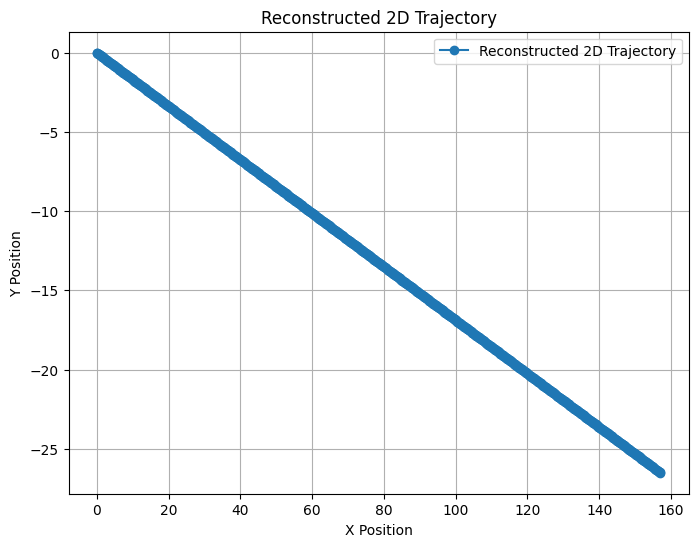

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize the starting position and orientation (can be set to 0,0,0 or any initial point)
x_total, y_total = 0.0, 0.0
x_positions, y_positions = [x_total], [y_total]
yaw_angles = [0.0]  # Starting yaw is 0

all_outputs = torch.cat(outputs, dim=0)

# Iterate over each result in outputs and accumulate position and orientation
for output in all_outputs:
    # Extract position and orientation deltas
    dx, dy, dz, droll, dpitch, dyaw = output[0], output[1], output[2], output[3], output[4], output[5]

    # Accumulate position
    x_total += dx.item()
    y_total += dy.item()
    
    # Accumulate orientation (yaw angle in this case)
    current_yaw = yaw_angles[-1] + dyaw  # Update yaw by adding the change
    
    # Store the updated positions and orientations
    x_positions.append(x_total)
    #print(x_total)
    y_positions.append(y_total)
    yaw_angles.append(current_yaw)

# Now we have the reconstructed trajectory
plt.figure(figsize=(8, 6))
plt.plot(x_positions, y_positions, marker='o', linestyle='-', label="Reconstructed 2D Trajectory")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Reconstructed 2D Trajectory")
plt.legend()
plt.grid(True)
plt.show()


(801, 12)


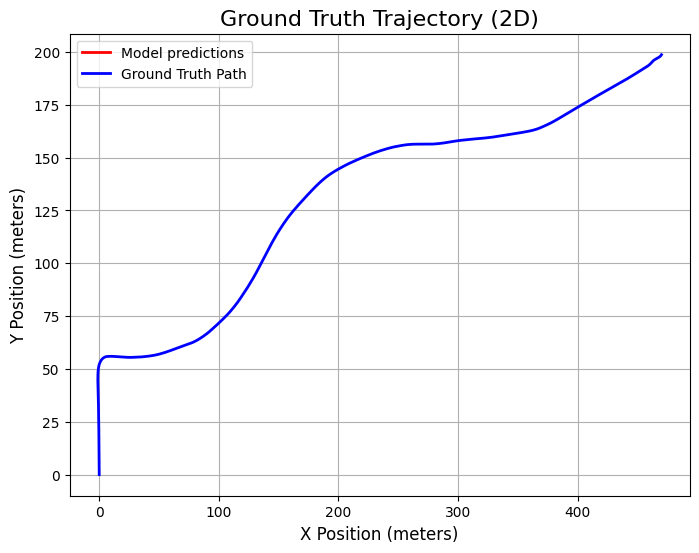

In [44]:


# Load the ground truth poses (1x12 vectors from the 'poses.txt' file)
ground_truth_poses = np.loadtxt('03.txt')  # shape: (N, 12)

print(ground_truth_poses.shape)

# Extract x and y coordinates (ignoring the orientation)
ground_truth_poses = ground_truth_poses.reshape(len(ground_truth_poses), 3, 4) #reshape into Homogeneous matrix

x_positions = ground_truth_poses[:,:,-1][:, 0]
y_positions = ground_truth_poses[:,:,-1][:, 2] # z is the y coordinate in the 2D plane seen from above (z points forward in the camera frame)


# replace this with your model predictions
pred_poses_x = all_outputs[:, 0].cpu().numpy()  # x values
pred_poses_y = all_outputs[:, 1].cpu().numpy()  # y values

# calculate metrics
# rmse = ...

# Plot the ground truth trajectory in 2D (X-Y plane)
plt.figure(figsize=(8, 6))
plt.plot(pred_poses_x, pred_poses_y, label='Model predictions', color='r', linewidth=2)
plt.plot(x_positions, y_positions, label='Ground Truth Path', color='b', linewidth=2)
plt.title('Ground Truth Trajectory (2D)', fontsize=16)
plt.xlabel('X Position (meters)', fontsize=12)
plt.ylabel('Y Position (meters)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()